# Self-driving car Nanodegree - Term 1

## Project 2: **Behavior Cloning** 
***
In this project, we will use deep neural networks and convolutional neural networks to clone driving behavior. The model will output a steering angle to an autonomous vehicle.

Author : [Tran Ly Vu](https://github.com/tranlyvu)

- [Github repo](https://github.com/tranlyvu/autonomous-vehicle-projects/tree/master/Behavioral%20Cloning)
- [Notebook](http://nbviewer.jupyter.org/gist/tranlyvu/671c4e258dcc5535f27e458e346c64e9)
- [Python code](https://github.com/tranlyvu/autonomous-vehicle-projects/blob/master/Behavioral%20Cloning/src/behavior_cloning.py)

---
### Importing packages

In [1]:
import csv
from keras.models import Sequential
from keras.layers import Flatten, Dense, Convolution2D, Cropping2D, Lambda, Dropout
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
from keras.layers.pooling import MaxPooling2D
# Visualizations will be shown in the notebook.
%matplotlib inline

Using TensorFlow backend.


---
#### Loading the data

In [2]:
'''Read data'''
image_path = '../../../data'
# row in log path is IMG/<name>
driving_log_path = '../../../data/driving_log.csv'

rows = []
with open(driving_log_path) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        rows.append(row)

### First attempt
In [my first attempt](https://github.com/tranlyvu/autonomous-vehicle-projects/blob/master/Behavioral%20Cloning/src/first_attempt.py), I used 9-layers network from [end to end learning for self-driving cars](https://arxiv.org/pdf/1604.07316.pdf) by NVIDIA 

1. Pre-processing pipeline
    - Data augmentation: Fliping the image horizontal (from function append_data)
    - Cropping the image
    - Normalization and Mean centering
2. NVIDIA original model
    
|Layer   |type    |output filter/neurons|
|--------|--------|--------|
|1       |conv    |24      |
|2       |conv    |36      |
|3       |conv    |48      |
|4       |conv    |64      |
|5       |conv    |64      |
|6       |flattern|1164    |
|7       |relu    |100     |
|8       |relu    |50      |
|9       |relu    |10      |
|10      |relu    |1       |

---
### Second attempt

However, I detected overfitting in my first attempt, and hence i tried to improved the mode in second model by using regulation, i.e dropout

1. Pre-processing pipeline
    - Data augmentation: Fliping the image horizontal (from function append_data)
    - Cropping the image
    - Normalization and Mean centering
2. Modified NVIDIA model
    
|Layer   |type    |output filter/neurons|
|--------|--------|--------|
|1       |conv    |24      |
|        |dropout |        |
|2       |conv    |36      |
|        |dropout |        |
|3       |conv    |48      |
|        |dropout |        |
|4       |conv    |64      |
|5       |conv    |64      |
|6       |flattern|1164    |
|7       |relu    |100     |
|8       |relu    |50      |
|9       |relu    |10      |
|10      |relu    |1       |

In [3]:
def append_data(col, images, measurement, steering_measurements):
    current_path = image_path + '/' + col.strip()
    
    image = cv2.imread(current_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(np.asarray(image))
    steering_measurements.append(measurement)
    
    # random flipping
    flip_prob = np.random.random()
    if flip_prob > 0.5:
        image_flipped = np.fliplr(image)
        images.append(np.asarray(image_flipped))
        measurement_flipped = measurement * (-1)
        steering_measurements.append(measurement)
          

def images_and_measurements(sample):
    images = []
    steering_measurements = []
    for line in sample[0:]:
        measurement = float(line[3])
        ## random data
        camera = np.random.choice(['center', 'left', 'right'])
        if camera == 'center':
            col_center = line[0]
            append_data(col_center, images, measurement, steering_measurements)
        elif camera == 'left':
            col_left = line[1]
            append_data(col_left, images, measurement + 0.35, steering_measurements)
        else:
            col_right = line[2]
            append_data(col_right, images, measurement - 0.35, steering_measurements)
    return images, steering_measurements

def generator(samples, batch_size = 32):
    num_samples = len(samples)
    while 1:
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]           
            images = []
            measurements = []
            for image, measurement in batch_samples:
                images.append(image)   
                measurements.append(measurement)
            # trim image to only see section with road
            x_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(x_train, y_train)


In [4]:
## Print total number of data , including augmentation
X_total, y_total = images_and_measurements(rows[1:])
print("Number of image is: ", len(X_total))
print("Number of measurement is: ", len(y_total))

Number of image is:  12016
Number of measurement is:  12016


#### Model architecture definition

In [5]:
model = Sequential()
#The cameras in the simulator capture 160 pixel by 320 pixel images., after cropping, it is 66x200
model.add(Cropping2D(cropping = ((74,20), (60,60)),input_shape=(160, 320, 3)))

model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(66, 200, 3)))
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))
model.add(Dropout(.5))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))
model.add(Dropout(.5))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))
model.add(Dropout(.5))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))  
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
'''Training: using MSE for regression'''
model.compile(loss='mse', optimizer='adam')

---
#### Training model

In [6]:
print('Training model')            
samples = list(zip(X_total, y_total))          
train_samples, validation_samples = train_test_split(samples, test_size = 0.2)
train_generator = generator(train_samples, batch_size = 32)
validation_generator = generator(validation_samples, batch_size = 32)

history_object = model.fit_generator(train_generator,
                                    samples_per_epoch = len(train_samples),
                                    validation_data = validation_generator,
                                    nb_val_samples = len(validation_samples),
                                    nb_epoch = 10, 
                                    verbose = 1)
print('Endding training, starting to save model')
model.save('../model.h5')

Training model
Epoch 1/10
9612/9612 [==============================] - 18s - loss: 0.0892 - val_loss: 0.0772
Epoch 2/10
9612/9612 [==============================] - 15s - loss: 0.0771 - val_loss: 0.0674
Epoch 3/10
9612/9612 [==============================] - 15s - loss: 0.0688 - val_loss: 0.0640
Epoch 4/10
9612/9612 [==============================] - 15s - loss: 0.0625 - val_loss: 0.0553
Epoch 5/10
9612/9612 [==============================] - 15s - loss: 0.0585 - val_loss: 0.0533
Epoch 6/10
9612/9612 [==============================] - 15s - loss: 0.0561 - val_loss: 0.0521
Epoch 7/10
9612/9612 [==============================] - 15s - loss: 0.0547 - val_loss: 0.0502
Epoch 8/10
9612/9612 [==============================] - 15s - loss: 0.0521 - val_loss: 0.0481
Epoch 9/10
9612/9612 [==============================] - 15s - loss: 0.0495 - val_loss: 0.0481
Epoch 10/10
9612/9612 [==============================] - 15s - loss: 0.0484 - val_loss: 0.0469
Endding training, starting to save model


dict_keys(['loss', 'val_loss'])


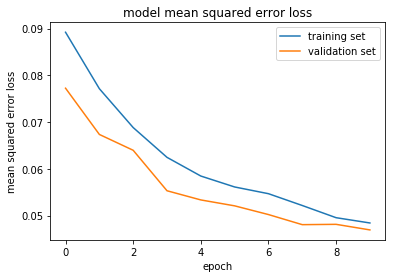

In [7]:
print(history_object.history.keys())
###plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()